<a href="https://colab.research.google.com/github/scardenol/ai_2023/blob/main/2.%20Hybrid%20supervised/GAN/src/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!mkdir input
!mkdir outputs

mkdir: cannot create directory ‘input’: File exists
mkdir: cannot create directory ‘outputs’: File exists


In [36]:
%%writefile vanilla_gan.py

Overwriting vanilla_gan.py


In [37]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

to_pil_image = transforms.ToPILImage()

train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

print('##### GENERATOR #####')
print(generator)
print('######################')

print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function
criterion = nn.BCELoss()

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)


    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss    

# create the noise vector
noise = create_noise(sample_size, nz)

generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)

    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

# plot and save the generator and discriminator loss
#plt.figure()
#plt.plot(losses_g, label='Generator loss')
#plt.plot(losses_d, label='Discriminator Loss')
#plt.legend()
#plt.savefig('outputs/loss.png')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

118it [00:17,  6.74it/s]                         


Epoch 0 of 200
Generator loss: 1.34028637, Discriminator loss: 0.91250199


118it [00:17,  6.71it/s]                         


Epoch 1 of 200
Generator loss: 2.23499084, Discriminator loss: 1.31741405


118it [00:16,  7.08it/s]                         


Epoch 2 of 200
Generator loss: 3.19724393, Discriminator loss: 0.78439420


118it [00:16,  7.16it/s]                         


Epoch 3 of 200
Generator loss: 3.46748114, Discriminator loss: 0.88423818


118it [00:17,  6.77it/s]                         


Epoch 4 of 200
Generator loss: 4.61785603, Discriminator loss: 0.51729137


118it [00:17,  6.93it/s]                         


Epoch 5 of 200
Generator loss: 1.80271292, Discriminator loss: 1.01565516


118it [00:17,  6.78it/s]                         


Epoch 6 of 200
Generator loss: 2.30752373, Discriminator loss: 1.10123885


118it [00:17,  6.67it/s]                         


Epoch 7 of 200
Generator loss: 1.72195613, Discriminator loss: 1.10023463


118it [00:17,  6.90it/s]                         


Epoch 8 of 200
Generator loss: 2.40377879, Discriminator loss: 1.06883156


118it [00:17,  6.71it/s]                         


Epoch 9 of 200
Generator loss: 1.65498924, Discriminator loss: 0.93050343


118it [00:16,  7.10it/s]                         


Epoch 10 of 200
Generator loss: 3.41399193, Discriminator loss: 0.99350065


118it [00:16,  7.07it/s]                         


Epoch 11 of 200
Generator loss: 1.18775010, Discriminator loss: 1.26000988


118it [00:17,  6.74it/s]                         


Epoch 12 of 200
Generator loss: 1.39976180, Discriminator loss: 1.01246798


118it [00:16,  7.11it/s]                         


Epoch 13 of 200
Generator loss: 0.92195332, Discriminator loss: 1.26196253


118it [00:16,  7.01it/s]                         


Epoch 14 of 200
Generator loss: 2.12565398, Discriminator loss: 0.94445187


118it [00:17,  6.90it/s]                         


Epoch 15 of 200
Generator loss: 1.92791784, Discriminator loss: 0.91344130


118it [00:16,  7.08it/s]                         


Epoch 16 of 200
Generator loss: 1.49934781, Discriminator loss: 0.97698510


118it [00:17,  6.87it/s]                         


Epoch 17 of 200
Generator loss: 2.09065962, Discriminator loss: 1.16505396


118it [00:16,  7.01it/s]                         


Epoch 18 of 200
Generator loss: 1.75608313, Discriminator loss: 0.80992496


118it [00:16,  7.02it/s]                         


Epoch 19 of 200
Generator loss: 1.98314643, Discriminator loss: 0.83172244


118it [00:17,  6.80it/s]                         


Epoch 20 of 200
Generator loss: 2.69858789, Discriminator loss: 0.76892686


118it [00:16,  6.98it/s]                         


Epoch 21 of 200
Generator loss: 2.01824546, Discriminator loss: 0.78624576


118it [00:16,  7.10it/s]                         


Epoch 22 of 200
Generator loss: 2.57686591, Discriminator loss: 0.63167179


118it [00:17,  6.79it/s]                         


Epoch 23 of 200
Generator loss: 2.44203043, Discriminator loss: 0.59121644


118it [00:16,  7.08it/s]                         


Epoch 24 of 200
Generator loss: 2.54161549, Discriminator loss: 0.65475959


118it [00:16,  7.04it/s]                         


Epoch 25 of 200
Generator loss: 2.19707632, Discriminator loss: 0.75732797


118it [00:17,  6.78it/s]                         


Epoch 26 of 200
Generator loss: 2.34816933, Discriminator loss: 0.56657952


118it [00:16,  7.07it/s]                         


Epoch 27 of 200
Generator loss: 2.96534967, Discriminator loss: 0.52326018


118it [00:17,  6.86it/s]                         


Epoch 28 of 200
Generator loss: 3.03183460, Discriminator loss: 0.54079437


118it [00:16,  7.01it/s]                         


Epoch 29 of 200
Generator loss: 2.34611964, Discriminator loss: 0.63305175


118it [00:16,  7.01it/s]                         


Epoch 30 of 200
Generator loss: 2.63266516, Discriminator loss: 0.64191651


118it [00:17,  6.70it/s]                         


Epoch 31 of 200
Generator loss: 2.56275105, Discriminator loss: 0.57611036


118it [00:16,  7.11it/s]                         


Epoch 32 of 200
Generator loss: 2.42170715, Discriminator loss: 0.66609341


118it [00:17,  6.94it/s]                         


Epoch 33 of 200
Generator loss: 1.89113772, Discriminator loss: 0.74009764


118it [00:17,  6.68it/s]                         


Epoch 34 of 200
Generator loss: 2.48327518, Discriminator loss: 0.58176816


118it [00:17,  6.87it/s]                         


Epoch 35 of 200
Generator loss: 2.34133339, Discriminator loss: 0.59073865


118it [00:17,  6.71it/s]                         


Epoch 36 of 200
Generator loss: 2.30751395, Discriminator loss: 0.64506465


118it [00:16,  7.05it/s]                         


Epoch 37 of 200
Generator loss: 2.61277604, Discriminator loss: 0.56418997


118it [00:16,  6.95it/s]                         


Epoch 38 of 200
Generator loss: 2.64351344, Discriminator loss: 0.54607809


118it [00:17,  6.74it/s]                         


Epoch 39 of 200
Generator loss: 2.56052232, Discriminator loss: 0.53301460


118it [00:16,  7.17it/s]                         


Epoch 40 of 200
Generator loss: 2.55797815, Discriminator loss: 0.59009075


118it [00:16,  7.12it/s]                         


Epoch 41 of 200
Generator loss: 2.27607036, Discriminator loss: 0.71731693


118it [00:17,  6.75it/s]                         


Epoch 42 of 200
Generator loss: 2.31827736, Discriminator loss: 0.63340479


118it [00:16,  7.05it/s]                         


Epoch 43 of 200
Generator loss: 2.27243996, Discriminator loss: 0.60363489


118it [00:16,  7.02it/s]                         


Epoch 44 of 200
Generator loss: 2.52668643, Discriminator loss: 0.53549010


118it [00:17,  6.75it/s]                         


Epoch 45 of 200
Generator loss: 2.47957110, Discriminator loss: 0.65219885


118it [00:16,  7.01it/s]                         


Epoch 46 of 200
Generator loss: 2.75380230, Discriminator loss: 0.56740928


118it [00:17,  6.77it/s]                         


Epoch 47 of 200
Generator loss: 2.56388879, Discriminator loss: 0.59272736


118it [00:16,  6.95it/s]                         


Epoch 48 of 200
Generator loss: 2.51472092, Discriminator loss: 0.65947431


118it [00:16,  6.96it/s]                         


Epoch 49 of 200
Generator loss: 2.24999952, Discriminator loss: 0.64215708


118it [00:17,  6.79it/s]                         


Epoch 50 of 200
Generator loss: 2.72806787, Discriminator loss: 0.52378476


118it [00:16,  7.07it/s]                         


Epoch 51 of 200
Generator loss: 2.96786857, Discriminator loss: 0.49811730


118it [00:16,  7.08it/s]                         


Epoch 52 of 200
Generator loss: 3.06722665, Discriminator loss: 0.57318252


118it [00:17,  6.78it/s]                         


Epoch 53 of 200
Generator loss: 2.64020777, Discriminator loss: 0.57034433


118it [00:16,  7.06it/s]                         


Epoch 54 of 200
Generator loss: 2.90832686, Discriminator loss: 0.56511641


118it [00:16,  7.25it/s]                         


Epoch 55 of 200
Generator loss: 2.93037510, Discriminator loss: 0.58318043


118it [00:17,  6.82it/s]                         


Epoch 56 of 200
Generator loss: 2.75329924, Discriminator loss: 0.53873372


118it [00:16,  7.20it/s]                         


Epoch 57 of 200
Generator loss: 2.68326163, Discriminator loss: 0.54044795


118it [00:16,  7.19it/s]                         


Epoch 58 of 200
Generator loss: 2.85070252, Discriminator loss: 0.53128552


118it [00:17,  6.81it/s]                         


Epoch 59 of 200
Generator loss: 2.69968867, Discriminator loss: 0.58982849


118it [00:16,  7.19it/s]                         


Epoch 60 of 200
Generator loss: 2.64037561, Discriminator loss: 0.58427268


118it [00:16,  7.04it/s]                         


Epoch 61 of 200
Generator loss: 2.76072574, Discriminator loss: 0.58512318


118it [00:16,  6.95it/s]                         


Epoch 62 of 200
Generator loss: 2.76845551, Discriminator loss: 0.53409487


118it [00:16,  7.17it/s]                         


Epoch 63 of 200
Generator loss: 2.74452853, Discriminator loss: 0.59162849


118it [00:16,  7.10it/s]                         


Epoch 64 of 200
Generator loss: 2.64004207, Discriminator loss: 0.61114967


118it [00:16,  6.98it/s]                         


Epoch 65 of 200
Generator loss: 2.49700975, Discriminator loss: 0.59741509


118it [00:16,  7.17it/s]                         


Epoch 66 of 200
Generator loss: 2.84384465, Discriminator loss: 0.53457791


118it [00:16,  7.25it/s]                         


Epoch 67 of 200
Generator loss: 2.61285853, Discriminator loss: 0.62317050


118it [00:17,  6.88it/s]                         


Epoch 68 of 200
Generator loss: 2.65558791, Discriminator loss: 0.60192168


118it [00:16,  7.18it/s]                         


Epoch 69 of 200
Generator loss: 2.55829358, Discriminator loss: 0.61079854


118it [00:16,  7.08it/s]                         


Epoch 70 of 200
Generator loss: 2.82864213, Discriminator loss: 0.55137098


118it [00:16,  7.00it/s]                         


Epoch 71 of 200
Generator loss: 2.84575319, Discriminator loss: 0.55377984


118it [00:16,  7.12it/s]                         


Epoch 72 of 200
Generator loss: 2.60827947, Discriminator loss: 0.60916179


118it [00:16,  7.02it/s]                         


Epoch 73 of 200
Generator loss: 2.61340523, Discriminator loss: 0.59352982


118it [00:16,  7.03it/s]                         


Epoch 74 of 200
Generator loss: 2.67598963, Discriminator loss: 0.57239723


118it [00:16,  7.17it/s]                         


Epoch 75 of 200
Generator loss: 2.56947994, Discriminator loss: 0.61756545


118it [00:16,  7.25it/s]                         


Epoch 76 of 200
Generator loss: 2.36822462, Discriminator loss: 0.66773784


118it [00:16,  7.07it/s]                         


Epoch 77 of 200
Generator loss: 2.16091633, Discriminator loss: 0.77708024


118it [00:16,  6.99it/s]                         


Epoch 78 of 200
Generator loss: 2.28952670, Discriminator loss: 0.71698493


118it [00:17,  6.88it/s]                         


Epoch 79 of 200
Generator loss: 2.40570807, Discriminator loss: 0.62003672


118it [00:17,  6.80it/s]                         


Epoch 80 of 200
Generator loss: 2.43169665, Discriminator loss: 0.63420904


118it [00:16,  6.96it/s]                         


Epoch 81 of 200
Generator loss: 2.43707991, Discriminator loss: 0.64738649


118it [00:17,  6.91it/s]                         


Epoch 82 of 200
Generator loss: 2.31669068, Discriminator loss: 0.69175851


118it [00:16,  7.24it/s]                         


Epoch 83 of 200
Generator loss: 2.27930021, Discriminator loss: 0.72279847


118it [00:16,  7.33it/s]                         


Epoch 84 of 200
Generator loss: 2.27654743, Discriminator loss: 0.68429804


118it [00:16,  7.03it/s]                         


Epoch 85 of 200
Generator loss: 2.44762564, Discriminator loss: 0.62962747


118it [00:16,  7.14it/s]                         


Epoch 86 of 200
Generator loss: 2.34325290, Discriminator loss: 0.67795277


118it [00:16,  7.25it/s]                         


Epoch 87 of 200
Generator loss: 2.31795979, Discriminator loss: 0.65637648


118it [00:16,  7.08it/s]                         


Epoch 88 of 200
Generator loss: 2.26962495, Discriminator loss: 0.68663538


118it [00:16,  7.09it/s]                         


Epoch 89 of 200
Generator loss: 2.22932339, Discriminator loss: 0.69579911


118it [00:16,  7.20it/s]                         


Epoch 90 of 200
Generator loss: 2.16390586, Discriminator loss: 0.71712250


118it [00:16,  7.14it/s]                         


Epoch 91 of 200
Generator loss: 2.04818749, Discriminator loss: 0.73941302


118it [00:16,  6.98it/s]                         


Epoch 92 of 200
Generator loss: 2.15503740, Discriminator loss: 0.72260636


118it [00:16,  7.23it/s]                         


Epoch 93 of 200
Generator loss: 2.14545560, Discriminator loss: 0.76351142


118it [00:16,  7.15it/s]                         


Epoch 94 of 200
Generator loss: 2.00073314, Discriminator loss: 0.77166939


118it [00:16,  6.97it/s]                         


Epoch 95 of 200
Generator loss: 2.06027508, Discriminator loss: 0.73589021


118it [00:16,  7.31it/s]                         


Epoch 96 of 200
Generator loss: 2.04258800, Discriminator loss: 0.74518102


118it [00:16,  7.20it/s]                         


Epoch 97 of 200
Generator loss: 2.08469820, Discriminator loss: 0.76040000


118it [00:16,  6.96it/s]                         


Epoch 98 of 200
Generator loss: 1.98996890, Discriminator loss: 0.77883148


118it [00:16,  7.31it/s]                         


Epoch 99 of 200
Generator loss: 2.00509048, Discriminator loss: 0.77351540


118it [00:16,  7.30it/s]                         


Epoch 100 of 200
Generator loss: 2.07010436, Discriminator loss: 0.76559895


118it [00:16,  6.96it/s]                         


Epoch 101 of 200
Generator loss: 2.01775861, Discriminator loss: 0.76300406


118it [00:16,  7.27it/s]                         


Epoch 102 of 200
Generator loss: 2.05789280, Discriminator loss: 0.75545561


118it [00:16,  7.25it/s]                         


Epoch 103 of 200
Generator loss: 1.98746049, Discriminator loss: 0.80253458


118it [00:16,  7.00it/s]                         


Epoch 104 of 200
Generator loss: 2.06696224, Discriminator loss: 0.78352982


118it [00:16,  7.25it/s]                         


Epoch 105 of 200
Generator loss: 1.93277514, Discriminator loss: 0.81603485


118it [00:16,  7.31it/s]                         


Epoch 106 of 200
Generator loss: 1.81263864, Discriminator loss: 0.86185366


118it [00:17,  6.94it/s]                         


Epoch 107 of 200
Generator loss: 1.86160207, Discriminator loss: 0.82090974


118it [00:16,  7.25it/s]                         


Epoch 108 of 200
Generator loss: 1.87691021, Discriminator loss: 0.81057209


118it [00:16,  7.32it/s]                         


Epoch 109 of 200
Generator loss: 1.88994312, Discriminator loss: 0.81125838


118it [00:17,  6.91it/s]                         


Epoch 110 of 200
Generator loss: 1.92722571, Discriminator loss: 0.83512276


118it [00:16,  7.23it/s]                         


Epoch 111 of 200
Generator loss: 1.85770345, Discriminator loss: 0.82401425


118it [00:16,  7.14it/s]                         


Epoch 112 of 200
Generator loss: 1.87685788, Discriminator loss: 0.82056284


118it [00:16,  6.97it/s]                         


Epoch 113 of 200
Generator loss: 1.86685181, Discriminator loss: 0.83103681


118it [00:16,  7.16it/s]                         


Epoch 114 of 200
Generator loss: 1.81633532, Discriminator loss: 0.87775254


118it [00:16,  7.30it/s]                         


Epoch 115 of 200
Generator loss: 1.72679198, Discriminator loss: 0.87621212


118it [00:16,  7.07it/s]                         


Epoch 116 of 200
Generator loss: 1.76690686, Discriminator loss: 0.88237882


118it [00:16,  7.04it/s]                         


Epoch 117 of 200
Generator loss: 1.77873647, Discriminator loss: 0.88331580


118it [00:16,  7.27it/s]                         


Epoch 118 of 200
Generator loss: 1.64399898, Discriminator loss: 0.91733158


118it [00:16,  7.27it/s]                         


Epoch 119 of 200
Generator loss: 1.70461249, Discriminator loss: 0.92932957


118it [00:16,  7.02it/s]                         


Epoch 120 of 200
Generator loss: 1.67080510, Discriminator loss: 0.91879809


118it [00:16,  7.22it/s]                         


Epoch 121 of 200
Generator loss: 1.67788231, Discriminator loss: 0.89575726


118it [00:16,  7.25it/s]                         


Epoch 122 of 200
Generator loss: 1.81819236, Discriminator loss: 0.86993313


118it [00:17,  6.90it/s]                         


Epoch 123 of 200
Generator loss: 1.78605127, Discriminator loss: 0.87798774


118it [00:16,  7.29it/s]                         


Epoch 124 of 200
Generator loss: 1.81451619, Discriminator loss: 0.85444582


118it [00:16,  7.32it/s]                         


Epoch 125 of 200
Generator loss: 1.79806459, Discriminator loss: 0.86384732


118it [00:16,  7.00it/s]                         


Epoch 126 of 200
Generator loss: 1.81361187, Discriminator loss: 0.85765988


118it [00:16,  7.29it/s]                         


Epoch 127 of 200
Generator loss: 1.70540547, Discriminator loss: 0.89789754


118it [00:16,  7.22it/s]                         


Epoch 128 of 200
Generator loss: 1.72853470, Discriminator loss: 0.87777382


118it [00:17,  6.93it/s]                         


Epoch 129 of 200
Generator loss: 1.70392823, Discriminator loss: 0.89766365


118it [00:16,  7.18it/s]                         


Epoch 130 of 200
Generator loss: 1.68918896, Discriminator loss: 0.89931840


118it [00:16,  7.29it/s]                         


Epoch 131 of 200
Generator loss: 1.71800458, Discriminator loss: 0.89473844


118it [00:17,  6.90it/s]                         


Epoch 132 of 200
Generator loss: 1.68719852, Discriminator loss: 0.89847541


118it [00:16,  7.32it/s]                         


Epoch 133 of 200
Generator loss: 1.69102943, Discriminator loss: 0.90712440


118it [00:15,  7.38it/s]                         


Epoch 134 of 200
Generator loss: 1.65688705, Discriminator loss: 0.92376393


118it [00:16,  7.06it/s]                         


Epoch 135 of 200
Generator loss: 1.64077377, Discriminator loss: 0.91894060


118it [00:16,  7.35it/s]                         


Epoch 136 of 200
Generator loss: 1.66645873, Discriminator loss: 0.94312495


118it [00:16,  7.32it/s]                         


Epoch 137 of 200
Generator loss: 1.56450224, Discriminator loss: 0.93702513


118it [00:16,  7.25it/s]                         


Epoch 138 of 200
Generator loss: 1.63794518, Discriminator loss: 0.93970668


118it [00:16,  7.20it/s]                         


Epoch 139 of 200
Generator loss: 1.67531288, Discriminator loss: 0.90333480


118it [00:16,  7.34it/s]                         


Epoch 140 of 200
Generator loss: 1.60096490, Discriminator loss: 0.92421895


118it [00:15,  7.45it/s]                         


Epoch 141 of 200
Generator loss: 1.71468866, Discriminator loss: 0.88691962


118it [00:16,  7.07it/s]                         


Epoch 142 of 200
Generator loss: 1.68860590, Discriminator loss: 0.90232038


118it [00:16,  7.30it/s]                         


Epoch 143 of 200
Generator loss: 1.77924442, Discriminator loss: 0.89731276


118it [00:15,  7.39it/s]                         


Epoch 144 of 200
Generator loss: 1.63795888, Discriminator loss: 0.92366356


118it [00:16,  7.02it/s]                         


Epoch 145 of 200
Generator loss: 1.53882682, Discriminator loss: 0.94753021


118it [00:15,  7.39it/s]                         


Epoch 146 of 200
Generator loss: 1.60733902, Discriminator loss: 0.93739659


118it [00:16,  7.27it/s]                         


Epoch 147 of 200
Generator loss: 1.56334448, Discriminator loss: 0.94264871


118it [00:16,  7.16it/s]                         


Epoch 148 of 200
Generator loss: 1.56082332, Discriminator loss: 0.95178813


118it [00:16,  7.27it/s]                         


Epoch 149 of 200
Generator loss: 1.50960684, Discriminator loss: 0.98737925


118it [00:15,  7.38it/s]                         


Epoch 150 of 200
Generator loss: 1.46667254, Discriminator loss: 1.00311935


118it [00:15,  7.44it/s]                         


Epoch 151 of 200
Generator loss: 1.48491693, Discriminator loss: 0.96879327


118it [00:16,  7.00it/s]                         


Epoch 152 of 200
Generator loss: 1.51359475, Discriminator loss: 0.96060222


118it [00:15,  7.40it/s]                         


Epoch 153 of 200
Generator loss: 1.56159341, Discriminator loss: 0.96317977


118it [00:15,  7.42it/s]                         


Epoch 154 of 200
Generator loss: 1.49962127, Discriminator loss: 0.97895640


118it [00:16,  7.08it/s]                         


Epoch 155 of 200
Generator loss: 1.47520685, Discriminator loss: 0.98986530


118it [00:15,  7.43it/s]                         


Epoch 156 of 200
Generator loss: 1.51693070, Discriminator loss: 0.98540729


118it [00:16,  7.37it/s]                         


Epoch 157 of 200
Generator loss: 1.48847163, Discriminator loss: 0.98288453


118it [00:16,  7.19it/s]                         


Epoch 158 of 200
Generator loss: 1.48424327, Discriminator loss: 0.99971563


118it [00:16,  7.23it/s]                         


Epoch 159 of 200
Generator loss: 1.45990908, Discriminator loss: 0.99026567


118it [00:15,  7.38it/s]                         


Epoch 160 of 200
Generator loss: 1.45065463, Discriminator loss: 0.99404871


118it [00:15,  7.43it/s]                         


Epoch 161 of 200
Generator loss: 1.41280222, Discriminator loss: 1.01928031


118it [00:16,  7.07it/s]                         


Epoch 162 of 200
Generator loss: 1.44963932, Discriminator loss: 1.01356566


118it [00:15,  7.48it/s]                         


Epoch 163 of 200
Generator loss: 1.44976437, Discriminator loss: 1.00052512


118it [00:16,  7.33it/s]                         


Epoch 164 of 200
Generator loss: 1.38000357, Discriminator loss: 1.02722955


118it [00:16,  7.03it/s]                         


Epoch 165 of 200
Generator loss: 1.37586021, Discriminator loss: 1.03122151


118it [00:16,  7.37it/s]                         


Epoch 166 of 200
Generator loss: 1.42580736, Discriminator loss: 1.02950823


118it [00:16,  7.21it/s]                         


Epoch 167 of 200
Generator loss: 1.42157733, Discriminator loss: 1.03233683


118it [00:16,  7.22it/s]                         


Epoch 168 of 200
Generator loss: 1.42566633, Discriminator loss: 1.00892842


118it [00:16,  7.26it/s]                         


Epoch 169 of 200
Generator loss: 1.42021132, Discriminator loss: 1.02343357


118it [00:15,  7.39it/s]                         


Epoch 170 of 200
Generator loss: 1.39189851, Discriminator loss: 1.01062810


118it [00:15,  7.42it/s]                         


Epoch 171 of 200
Generator loss: 1.46138561, Discriminator loss: 0.99419463


118it [00:16,  7.00it/s]                         


Epoch 172 of 200
Generator loss: 1.36573875, Discriminator loss: 1.04957128


118it [00:15,  7.46it/s]                         


Epoch 173 of 200
Generator loss: 1.33445823, Discriminator loss: 1.05925786


118it [00:15,  7.39it/s]                         


Epoch 174 of 200
Generator loss: 1.34421670, Discriminator loss: 1.04642868


118it [00:16,  7.00it/s]                         


Epoch 175 of 200
Generator loss: 1.34891462, Discriminator loss: 1.03950453


118it [00:15,  7.50it/s]                         


Epoch 176 of 200
Generator loss: 1.32628632, Discriminator loss: 1.06948864


118it [00:16,  7.32it/s]                         


Epoch 177 of 200
Generator loss: 1.34527123, Discriminator loss: 1.05100107


118it [00:16,  7.36it/s]                         


Epoch 178 of 200
Generator loss: 1.39190245, Discriminator loss: 1.03903937


118it [00:16,  7.13it/s]                         


Epoch 179 of 200
Generator loss: 1.34583890, Discriminator loss: 1.05224311


118it [00:16,  7.34it/s]                         


Epoch 180 of 200
Generator loss: 1.35614085, Discriminator loss: 1.04512262


118it [00:15,  7.42it/s]                         


Epoch 181 of 200
Generator loss: 1.39459682, Discriminator loss: 1.03798532


118it [00:16,  7.04it/s]                         


Epoch 182 of 200
Generator loss: 1.36645055, Discriminator loss: 1.04176748


118it [00:15,  7.44it/s]                         


Epoch 183 of 200
Generator loss: 1.34536612, Discriminator loss: 1.07150877


118it [00:16,  7.32it/s]                         


Epoch 184 of 200
Generator loss: 1.33435917, Discriminator loss: 1.06712437


118it [00:16,  7.06it/s]                         


Epoch 185 of 200
Generator loss: 1.32282698, Discriminator loss: 1.06542981


118it [00:16,  7.29it/s]                         


Epoch 186 of 200
Generator loss: 1.42396033, Discriminator loss: 1.04150474


118it [00:16,  7.37it/s]                         


Epoch 187 of 200
Generator loss: 1.38356757, Discriminator loss: 1.03607440


118it [00:16,  7.33it/s]                         


Epoch 188 of 200
Generator loss: 1.37643242, Discriminator loss: 1.03824461


118it [00:16,  7.20it/s]                         


Epoch 189 of 200
Generator loss: 1.37901568, Discriminator loss: 1.03590465


118it [00:15,  7.38it/s]                         


Epoch 190 of 200
Generator loss: 1.34287202, Discriminator loss: 1.03912735


118it [00:15,  7.39it/s]                         


Epoch 191 of 200
Generator loss: 1.35918796, Discriminator loss: 1.03756368


118it [00:16,  7.05it/s]                         


Epoch 192 of 200
Generator loss: 1.34812129, Discriminator loss: 1.04816890


118it [00:16,  7.37it/s]                         


Epoch 193 of 200
Generator loss: 1.33976650, Discriminator loss: 1.06269836


118it [00:16,  7.33it/s]                         


Epoch 194 of 200
Generator loss: 1.35520840, Discriminator loss: 1.06160867


118it [00:16,  7.12it/s]                         


Epoch 195 of 200
Generator loss: 1.32860112, Discriminator loss: 1.06646001


118it [00:15,  7.41it/s]                         


Epoch 196 of 200
Generator loss: 1.27642643, Discriminator loss: 1.07634175


118it [00:16,  7.24it/s]                         


Epoch 197 of 200
Generator loss: 1.32525730, Discriminator loss: 1.06405783


118it [00:16,  7.22it/s]                         


Epoch 198 of 200
Generator loss: 1.35964668, Discriminator loss: 1.05945921


118it [00:16,  7.25it/s]                         


Epoch 199 of 200
Generator loss: 1.36767292, Discriminator loss: 1.02851224
DONE TRAINING


In [3]:
!python vanilla_gan.py

100% 26421880/26421880 [00:01<00:00, 16076913.61it/s]
Extracting input/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to input/data/FashionMNIST/raw

100% 29515/29515 [00:00<00:00, 270402.55it/s]
Extracting input/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to input/data/FashionMNIST/raw

100% 4422102/4422102 [00:00<00:00, 5091696.54it/s]
Extracting input/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to input/data/FashionMNIST/raw

100% 5148/5148 [00:00<00:00, 31023386.48it/s]
Extracting input/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/FashionMNIST/raw

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bi

In [38]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [39]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

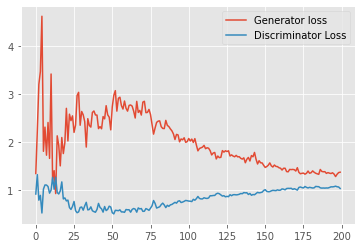

In [40]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot([losses_g[i].cpu().detach().numpy() for i in range (len(losses_g))], label='Generator loss')
plt.plot([losses_d[i].cpu().detach().numpy() for i in range (len(losses_d))], label='Discriminator Loss')
#plt.plot(losses_g, label='Generator loss')
#plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')